<a href="https://colab.research.google.com/github/OnyedikachiOnwuachuke/Stock-Price-Prediction-Using-Sentiment-Analysis/blob/main/PREDICTING_TESLA_STOCK_PRICE_USING_SENTIMENT_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####**IMPORT LIBRARIES**

In [29]:
# Importing necessary libraries
!pip install yfinance
import yfinance as yf
import os
from google.colab import drive
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose

# For Sentiment data analysis
import re
import nltk
from nltk.corpus import stopwords
from sklearn.pipeline import make_pipeline
from transformers import pipeline

# For machine learning models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# For time series models
from statsmodels.tsa.arima.model import ARIMA


# For LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

###**STOCK DATA**

In [2]:
# Loading the stock price data from yahoo finance with the company ticker

TSLA = yf.Ticker("TSLA")
# All the information about the the comapany ( Tesla Inc.)
TSLA.info

{'address1': '1 Tesla Road',
 'city': 'Austin',
 'state': 'TX',
 'zip': '78725',
 'country': 'United States',
 'phone': '512 516 8177',
 'website': 'https://www.tesla.com',
 'industry': 'Auto Manufacturers',
 'industryKey': 'auto-manufacturers',
 'industryDisp': 'Auto Manufacturers',
 'sector': 'Consumer Cyclical',
 'sectorKey': 'consumer-cyclical',
 'sectorDisp': 'Consumer Cyclical',
 'longBusinessSummary': 'Tesla, Inc. designs, develops, manufactures, leases, and sells electric vehicles, and energy generation and storage systems in the United States, China, and internationally. The company operates in two segments, Automotive, and Energy Generation and Storage. The Automotive segment offers electric vehicles, as well as sells automotive regulatory credits; and non-warranty after-sales vehicle, used vehicles, body shop and parts, supercharging, retail merchandise, and vehicle insurance services. This segment also provides sedans and sport utility vehicles through direct and used vehic

In [3]:
# To display, describe and give the necessary information about the stock data
stock_data = TSLA.history(period="max")
stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-27 00:00:00-05:00,341.799988,342.549988,326.589996,332.890015,57896400,0.0,0.0
2024-11-29 00:00:00-05:00,336.079987,345.450012,334.649994,345.160004,37167600,0.0,0.0
2024-12-02 00:00:00-05:00,352.380005,360.000000,351.149994,357.089996,77986500,0.0,0.0


In [4]:
# Check the data structure and summary of the stock data
print("Data Info:")
print(stock_data.info())

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3634 entries, 2010-06-29 00:00:00-04:00 to 2024-12-04 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3634 non-null   float64
 1   High          3634 non-null   float64
 2   Low           3634 non-null   float64
 3   Close         3634 non-null   float64
 4   Volume        3634 non-null   int64  
 5   Dividends     3634 non-null   float64
 6   Stock Splits  3634 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 227.1 KB
None


In [5]:
# Display basic statistical details of the stock data
print("\nStatistical Summary:")
print(stock_data.describe())



Statistical Summary:
              Open         High          Low        Close        Volume  \
count  3634.000000  3634.000000  3634.000000  3634.000000  3.634000e+03   
mean     79.834394    81.578384    77.978866    79.818008  9.668131e+07   
std     105.159877   107.486868   102.632576   105.092795  7.790474e+07   
min       1.076000     1.108667     0.998667     1.053333  1.777500e+06   
25%      12.011667    12.319000    11.736666    12.063833  4.867658e+07   
50%      17.825666    18.075666    17.538667    17.840000  8.198130e+07   
75%     175.765003   179.615005   173.020000   176.477493  1.224334e+08   
max     411.470001   414.496674   405.666656   409.970001  9.140820e+08   

       Dividends  Stock Splits  
count     3634.0   3634.000000  
mean         0.0      0.002201  
std          0.0      0.096715  
min          0.0      0.000000  
25%          0.0      0.000000  
50%          0.0      0.000000  
75%          0.0      0.000000  
max          0.0      5.000000  


In [6]:
# Check for missing values on the stock data
print("\nMissing Values:")
print(stock_data.isnull().sum())



Missing Values:
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


In [7]:
# Display the shape of the stock data
print("\nShape of the Data:")
print(stock_data.shape)


Shape of the Data:
(3634, 7)


In [8]:
#Drop the unnecssary columns for visualisations
stock_data = stock_data.drop(columns=['Volume', 'Dividends', 'Stock Splits'])
stock_data

,Open,High,Low,Close
Date,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000
...,...,...,...,...
2024-11-27 00:00:00-05:00,341.799988,342.549988,326.589996,332.890015
2024-11-29 00:00:00-05:00,336.079987,345.450012,334.649994,345.160004
2024-12-02 00:00:00-05:00,352.380005,360.000000,351.149994,357.089996


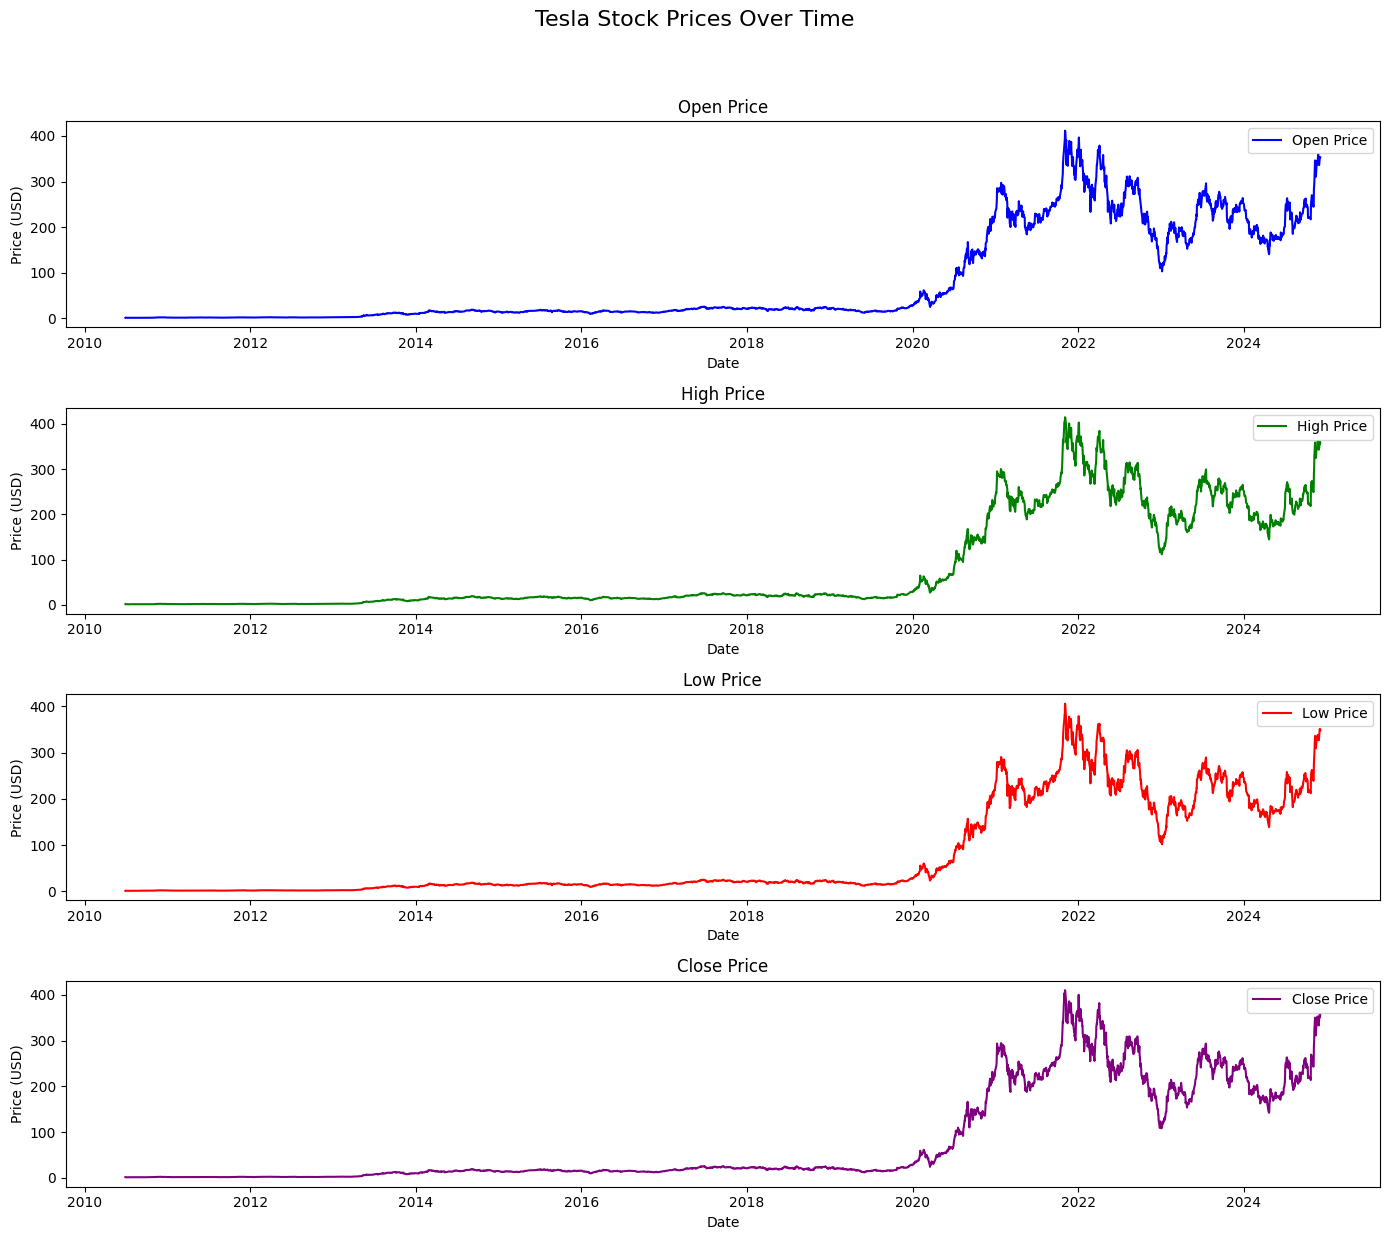

In [9]:
# Creating a 4x1 subplot for Open, High, Low, and Close prices without sharing the x-axis
fig, axs = plt.subplots(4, 1, figsize=(14, 13))
fig.suptitle('Tesla Stock Prices Over Time', fontsize=16)

# Plotting each price type in a separate subplot without shared x-axes
# 1. Open Price
axs[0].plot(stock_data.index, stock_data['Open'], label='Open Price', color='blue')
axs[0].set_title('Open Price')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price (USD)')
axs[0].legend()

# 2. High Price
axs[1].plot(stock_data.index, stock_data['High'], label='High Price',color='green')
axs[1].set_title('High Price')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price (USD)')
axs[1].legend()


# 3. Low Price
axs[2].plot(stock_data.index, stock_data['Low'], label='Low Price', color='red')
axs[2].set_title('Low Price')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Price (USD)')
axs[2].legend()

# 4. Close Price
axs[3].plot(stock_data.index, stock_data['Close'], label='Close Price',color='purple')
axs[3].set_title('Close Price')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Price (USD)')
axs[3].legend()

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


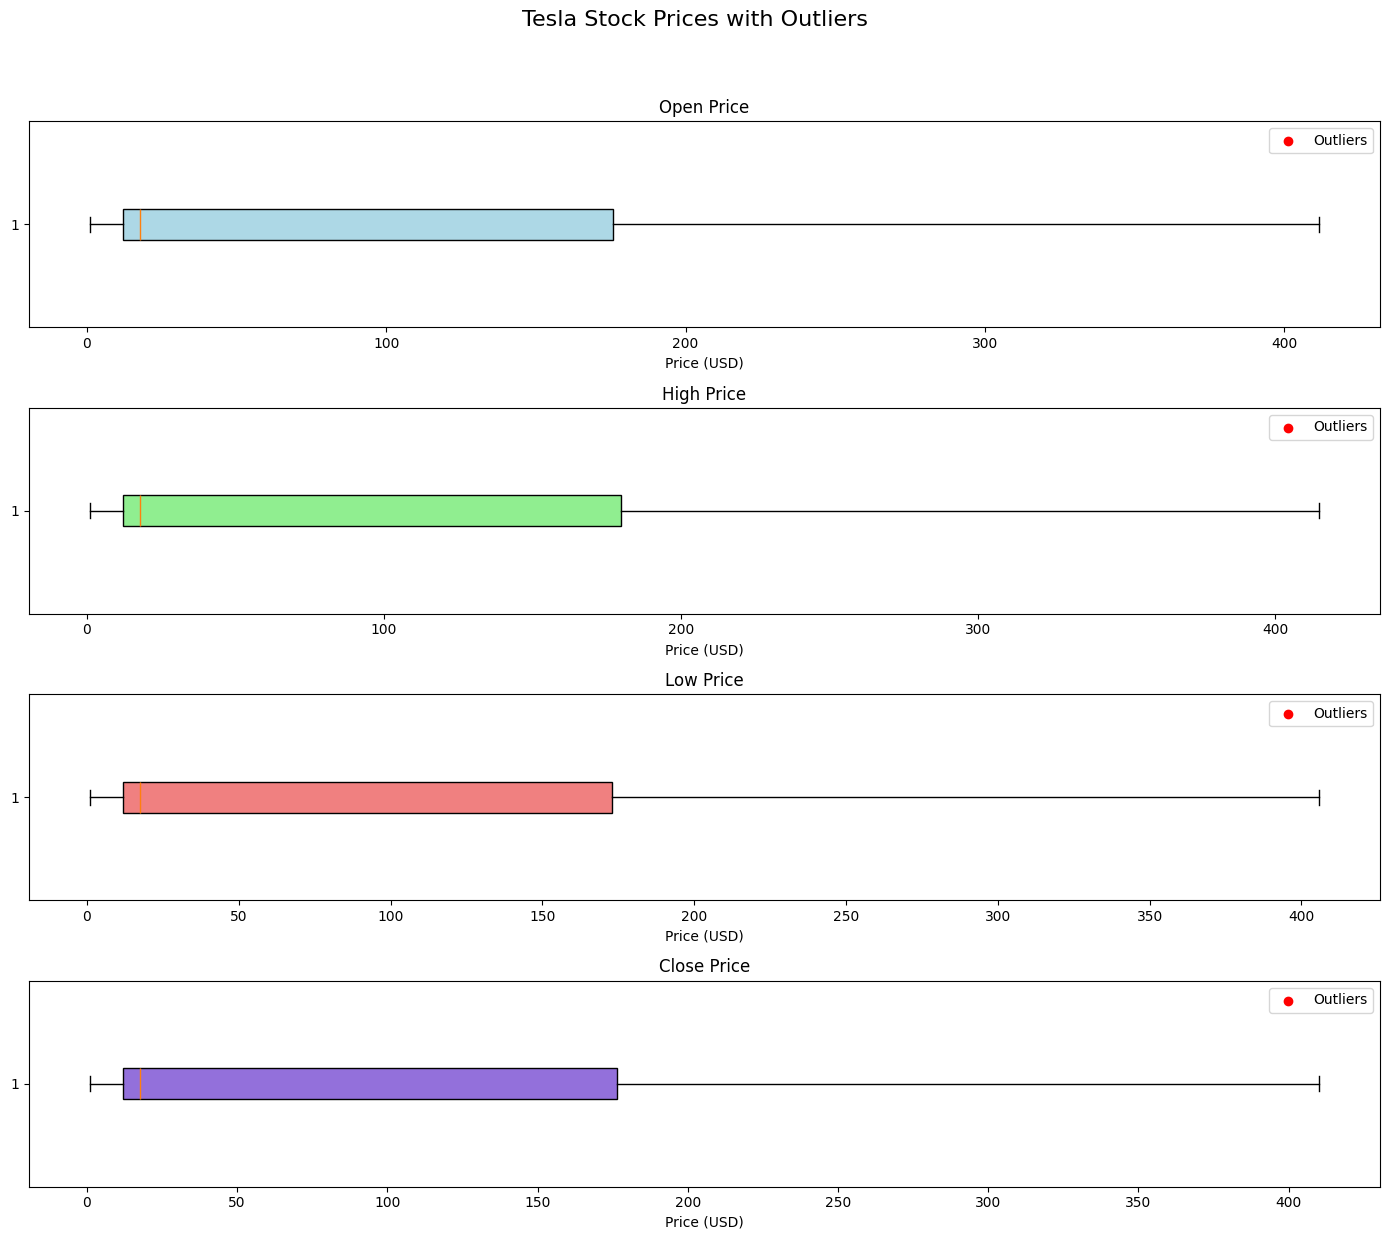

In [10]:
# Using the stock_data DataFrame with 'Open', 'High', 'Low', and 'Close' columns
data_column = stock_data[['Open', 'High', 'Low', 'Close']]

# Create a 4x1 subplot grid
fig, axs = plt.subplots(4, 1, figsize=(14, 13))
fig.suptitle('Tesla Stock Prices with Outliers', fontsize=16)

# Function to calculate outliers and plot boxplot with highlighting
def plot_box_with_outliers(data, ax, label, color):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]

    # Plot boxplot
    ax.boxplot(data, vert=False, patch_artist=True, boxprops=dict(facecolor=color))
    ax.scatter(outliers, [1] * len(outliers), color='red', label='Outliers', marker='o')

    ax.set_title(label)
    ax.set_xlabel('Price (USD)')
    ax.legend()

# Plot each price type with outliers
plot_box_with_outliers(stock_data['Open'], axs[0], 'Open Price', 'lightblue')
plot_box_with_outliers(stock_data['High'], axs[1], 'High Price', 'lightgreen')
plot_box_with_outliers(stock_data['Low'], axs[2], 'Low Price', 'lightcoral')
plot_box_with_outliers(stock_data['Close'], axs[3], 'Close Price', 'mediumpurple')  # Updated color

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


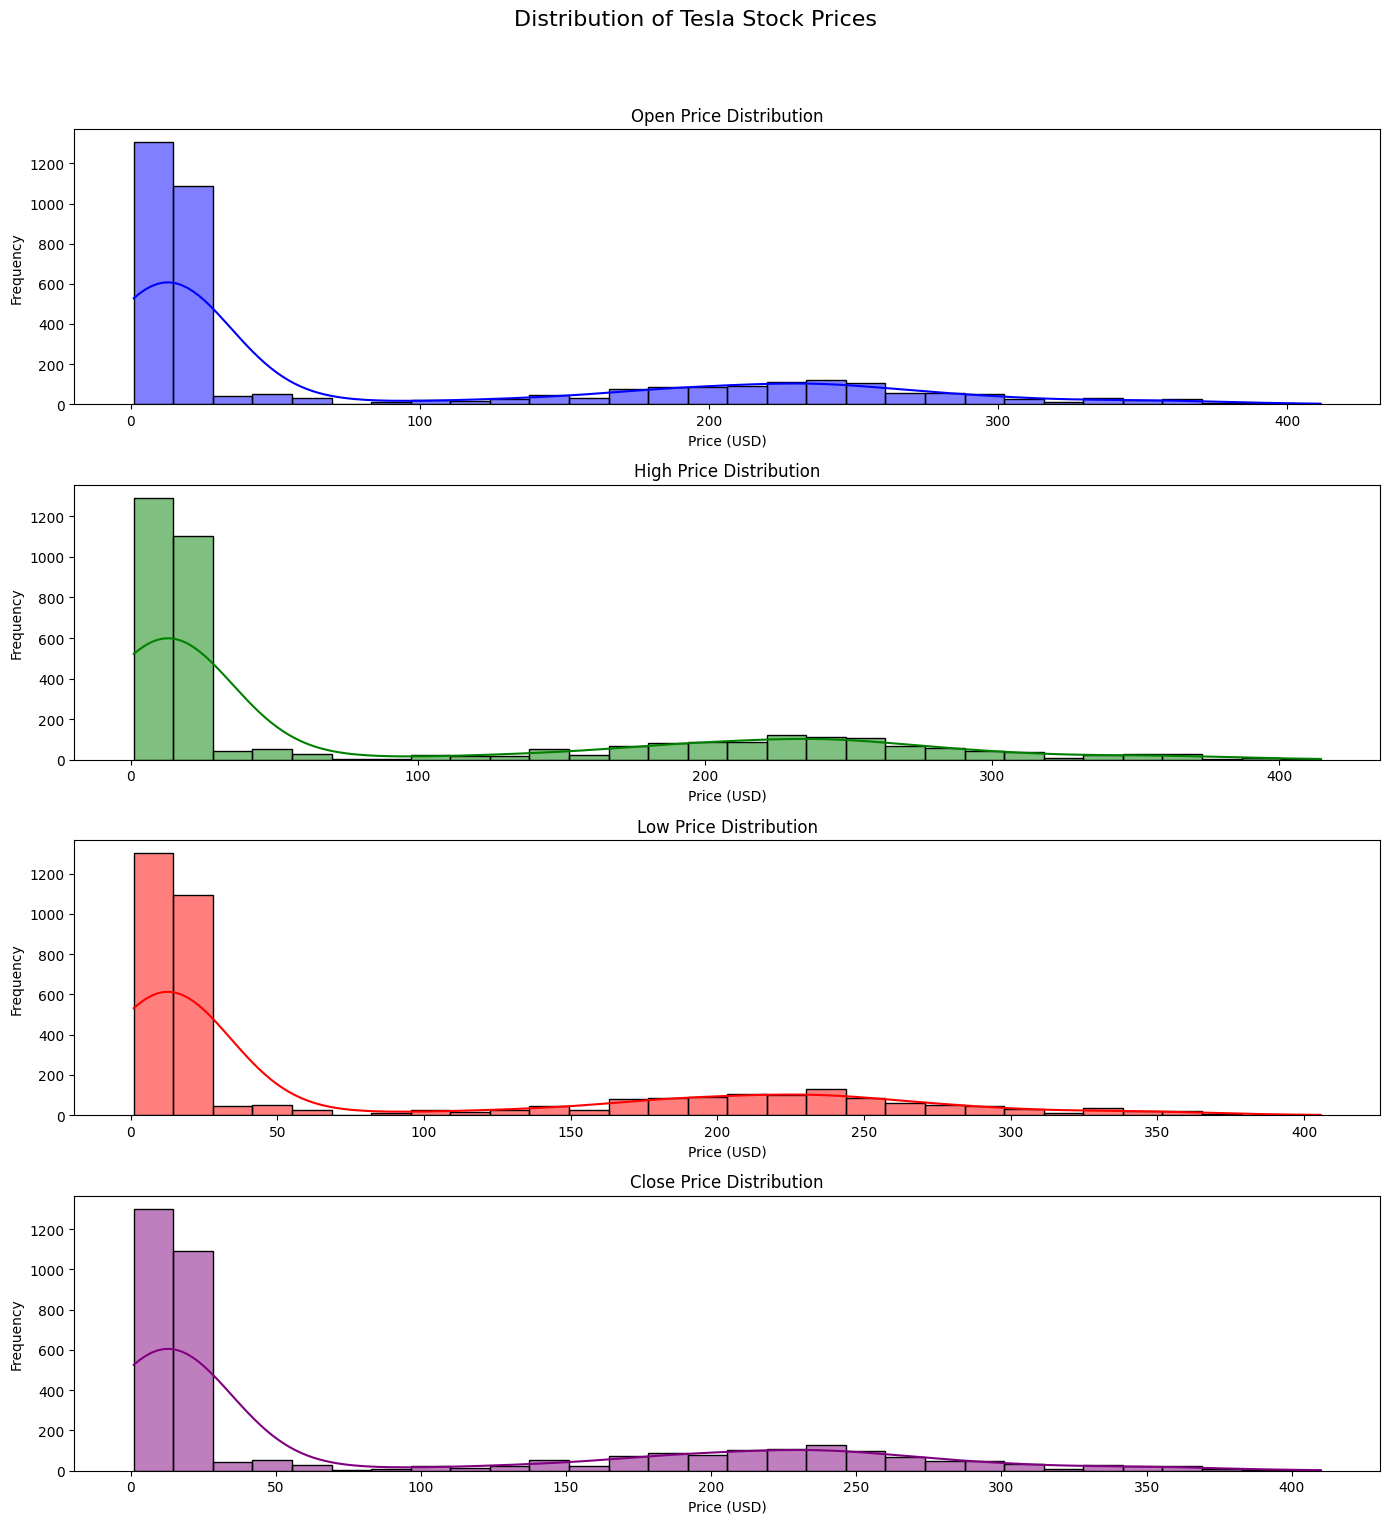

In [11]:
# Creating a 4x1 subplot for Open, High, Low, and Close price distributions
fig, axs = plt.subplots(4, 1, figsize=(14, 16))
fig.suptitle('Distribution of Tesla Stock Prices', fontsize=16)

# Plotting each price type as a histogram
# 1. Open Price Distribution
sns.histplot(stock_data['Open'], bins=30, kde=True, color='blue', ax=axs[0])
axs[0].set_title('Open Price Distribution')
axs[0].set_xlabel('Price (USD)')
axs[0].set_ylabel('Frequency')

# 2. High Price Distribution
sns.histplot(stock_data['High'], bins=30, kde=True, color='green', ax=axs[1])
axs[1].set_title('High Price Distribution')
axs[1].set_xlabel('Price (USD)')
axs[1].set_ylabel('Frequency')

# 3. Low Price Distribution
sns.histplot(stock_data['Low'], bins=30, kde=True, color='red', ax=axs[2])
axs[2].set_title('Low Price Distribution')
axs[2].set_xlabel('Price (USD)')
axs[2].set_ylabel('Frequency')

# 4. Close Price Distribution
sns.histplot(stock_data['Close'], bins=30, kde=True, color='purple', ax=axs[3])
axs[3].set_title('Close Price Distribution')
axs[3].set_xlabel('Price (USD)')
axs[3].set_ylabel('Frequency')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


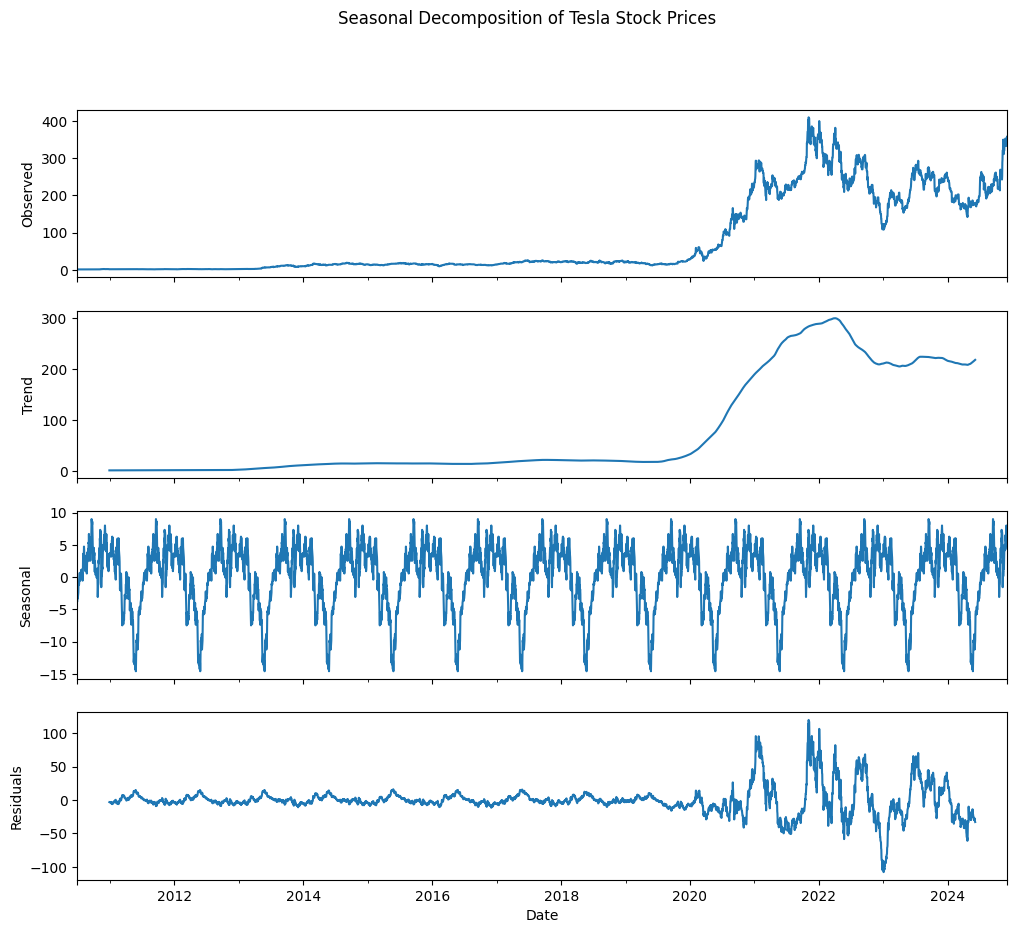

In [12]:
# The stock data is in daily frequency to ensure even time intervals
stock_data_daily = stock_data['Close'].resample('D').ffill()

# Perform seasonal decomposition on the 'Close' prices
decomposition = seasonal_decompose(stock_data_daily, model='additive', period=365)  # period=365 for daily data

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Seasonal Decomposition of Tesla Stock Prices')

decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')

decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residuals')
axes[3].set_xlabel('Date')

plt.show()

In [13]:
# Calculate Simple Moving Average (SMA) using the calculate_ma function
def calculate_ma(df, window):
    """
    Calculate the Simple Moving Average (MA/SMA) over a specified window.
    """
    return df['Close'].rolling(window=window).mean()

# Calculate 20-day and 50-day Moving Averages (MAs or SMAs)
stock_data['SMA_20'] = calculate_ma(stock_data, window=20)
stock_data['SMA_50'] = calculate_ma(stock_data, window=50)

# Exponential Moving Average (EMA)
def calculate_ema(df, span):
    """
    Calculate the Exponential Moving Average (EMA).
    """
    return df['Close'].ewm(span=span, adjust=False).mean()

# Calculate EMA 50 and EMA 200
stock_data['EMA_50'] = calculate_ema(stock_data, span=50)
stock_data['EMA_200'] = calculate_ema(stock_data, span=200)

# Moving Average Convergence/Divergence (MACD)
def calculate_macd(df, short_span=12, long_span=26, signal_span=9):
    """
    Calculate the MACD, Signal Line, and MACD Histogram.
    """
    short_ema = df['Close'].ewm(span=short_span, adjust=False).mean()
    long_ema = df['Close'].ewm(span=long_span, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_span, adjust=False).mean()
    macd_histogram = macd - signal
    return pd.DataFrame({'MACD': macd, 'Signal': signal, 'MACD_Histogram': macd_histogram})

# Calculate MACD, Signal Line, and MACD Histogram
macd_df = calculate_macd(stock_data)

# Add MACD components to the DataFrame
stock_data['MACD'] = macd_df['MACD']
stock_data['MACD_Signal'] = macd_df['Signal']
stock_data['MACD_Histogram'] = macd_df['MACD_Histogram']

# Relative Strength Index (RSI)
def calculate_rsi(df, window=14):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RSI
stock_data['RSI'] = calculate_rsi(stock_data)

# Average Directional Index (ADX)
def calculate_adx(df, window=14):
    high = df['High']
    low = df['Low']
    close = df['Close']

    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    plus_dm = high.diff()
    minus_dm = low.diff()

    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    atr = tr.rolling(window=window, min_periods=1).mean()
    plus_di = 100 * (plus_dm.ewm(alpha=1/window).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha=1/window).mean() / atr))

    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.ewm(alpha=1/window).mean()

    return pd.DataFrame({'ADX': adx, 'Plus_DI': plus_di, 'Minus_DI': minus_di})

# Calculate ADX, Plus_DI, and Minus_DI
adx_df = calculate_adx(stock_data)

# Add ADX components to the DataFrame
stock_data['ADX'] = adx_df['ADX']
stock_data['Plus_DI'] = adx_df['Plus_DI']
stock_data['Minus_DI'] = adx_df['Minus_DI']

# Drop rows with NaN values at the beginning of the dataset (if any)
stock_data.dropna(inplace=True)

# Display the first few rows of the updated DataFrame
stock_data.head()



,Open,High,Low,Close,SMA_20,SMA_50,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI
Date,,,,,,,,,,,,,,,
2010-09-08 00:00:00-04:00,1.377333,1.396667,1.373333,1.393333,1.301467,1.322240,1.361035,1.486359,0.013624,-0.001767,0.015391,67.149673,15.148664,32.092516,19.425309
2010-09-09 00:00:00-04:00,1.400000,1.403333,1.379333,1.380667,1.310833,1.318000,1.361805,1.485307,0.015075,0.001602,0.013474,65.047002,15.941895,32.222275,18.931977
2010-09-10 00:00:00-04:00,1.383333,1.395333,1.317333,1.344667,1.319400,1.313120,1.361133,1.483908,0.013169,0.003915,0.009254,58.093849,15.238047,28.376171,25.006138
2010-09-13 00:00:00-04:00,1.392667,1.393333,1.366667,1.381333,1.327400,1.311467,1.361925,1.482887,0.014450,0.006022,0.008428,54.812352,14.586735,27.918925,24.603195
2010-09-14 00:00:00-04:00,1.369333,1.440000,1.368667,1.408000,1.335200,1.314027,1.363732,1.482142,0.017416,0.008301,0.009115,67.142833,14.802616,32.856891,23.046153


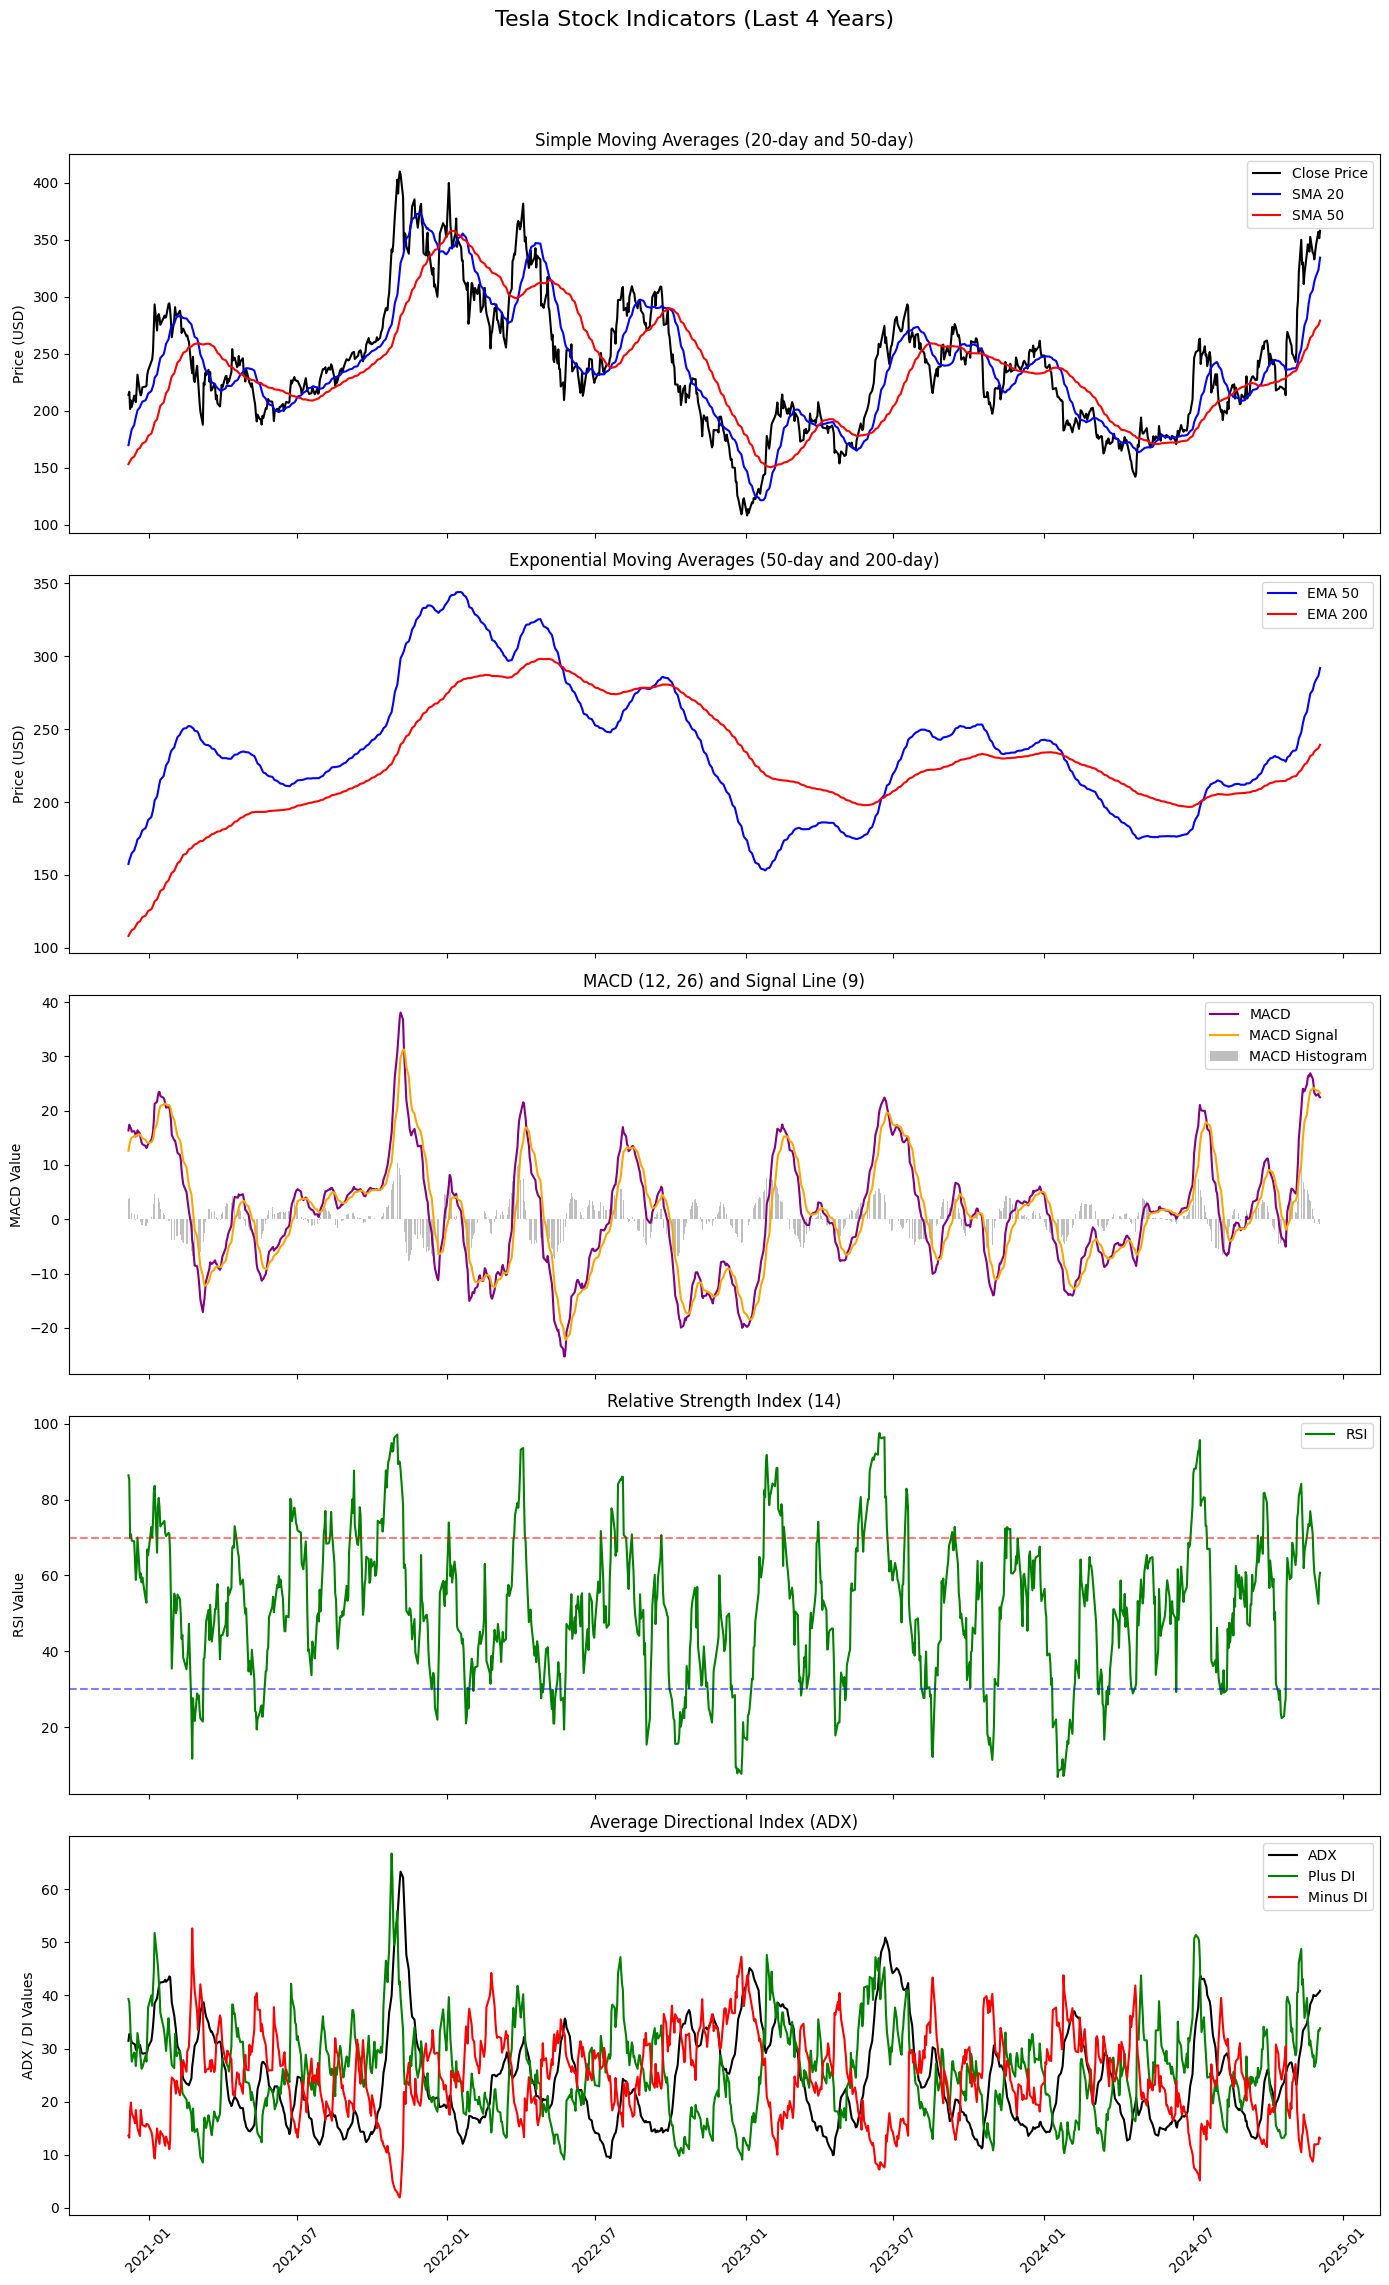

In [14]:
# Filtering the data for the last four years for visualising the necessary indicators
four_years_ago = stock_data.index.max() - timedelta(days=4*365)
filtered_data = stock_data[stock_data.index >= four_years_ago]

# Plot the indicators for the filtered data
fig, axs = plt.subplots(5, 1, figsize=(14, 24), sharex=True)
fig.suptitle('Tesla Stock Indicators (Last 4 Years)', fontsize=16)

# Plot SMAs and Closing Price
axs[0].plot(filtered_data.index, filtered_data['Close'], label='Close Price', color='black')
axs[0].plot(filtered_data.index, filtered_data['SMA_20'], label='SMA 20', color='blue')
axs[0].plot(filtered_data.index, filtered_data['SMA_50'], label='SMA 50', color='red')
axs[0].set_ylabel('Price (USD)')
axs[0].set_title('Simple Moving Averages (20-day and 50-day)')
axs[0].legend()

# Plot EMAs
axs[1].plot(filtered_data.index, filtered_data['EMA_50'], label='EMA 50', color='blue')
axs[1].plot(filtered_data.index, filtered_data['EMA_200'], label='EMA 200', color='red')
axs[1].set_ylabel('Price (USD)')
axs[1].set_title('Exponential Moving Averages (50-day and 200-day)')
axs[1].legend()

# Plot MACD
axs[2].plot(filtered_data.index, filtered_data['MACD'], label='MACD', color='purple')
axs[2].plot(filtered_data.index, filtered_data['MACD_Signal'], label='MACD Signal', color='orange')
axs[2].bar(filtered_data.index, filtered_data['MACD_Histogram'], label='MACD Histogram', color='grey', alpha=0.5)
axs[2].set_ylabel('MACD Value')
axs[2].set_title('MACD (12, 26) and Signal Line (9)')
axs[2].legend()

# Plot RSI
axs[3].plot(filtered_data.index, filtered_data['RSI'], label='RSI', color='green')
axs[3].axhline(70, linestyle='--', color='red', alpha=0.5)
axs[3].axhline(30, linestyle='--', color='blue', alpha=0.5)
axs[3].set_ylabel('RSI Value')
axs[3].set_title('Relative Strength Index (14)')
axs[3].legend()

# Plot ADX
axs[4].plot(filtered_data.index, filtered_data['ADX'], label='ADX', color='black')
axs[4].plot(filtered_data.index, filtered_data['Plus_DI'], label='Plus DI', color='green')
axs[4].plot(filtered_data.index, filtered_data['Minus_DI'], label='Minus DI', color='red')
axs[4].set_ylabel('ADX / DI Values')
axs[4].set_title('Average Directional Index (ADX)')
axs[4].legend()

plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


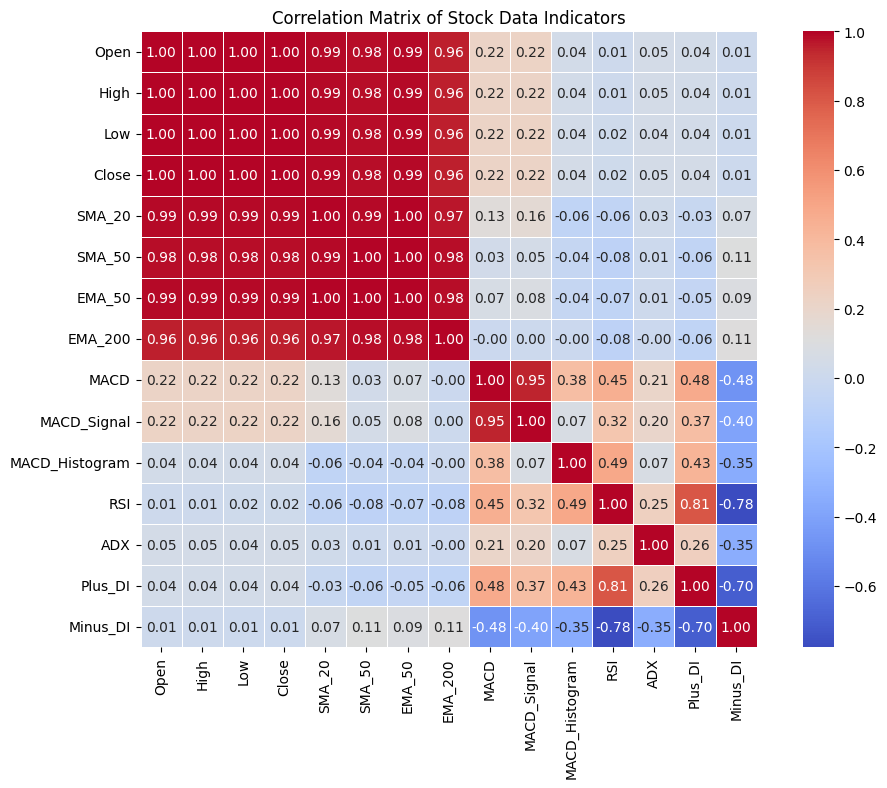

In [21]:
# Visualising the correlation matrix for the stock data
correlation_matrix = stock_data.corr()

# Set up thefigure size
plt.figure(figsize=(12, 8))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True,
            linewidths=.5, annot_kws={"size": 10})
plt.title('Correlation Matrix of Stock Data Indicators')
plt.show()


**STOCK DATA PREPROCESSING**


In [26]:

def preprocess_stock_data(data, start_date, end_date):
    """
    Preprocess stock data for the given date range and prepare it for training.

    Parameters:
        data (pd.DataFrame): The stock data with 'Date' as an index and columns ['Open', 'High', 'Low', 'Close', 'Volume', ...].
        start_date (str): Start date in the format 'YYYY-MM-DD'.
        end_date (str): End date in the format 'YYYY-MM-DD'.

    Returns:
        X_train, X_test, y_train, y_test: Training and testing datasets.
    """

    # Filter data within the specified date range
    filtered_data = data.loc[start_date:end_date]

    # Handle missing values (drop rows with NaNs)
    filtered_data = filtered_data.dropna()

    # Define the features (columns to be used for training)
    # We will use all columns except the 'Close' as features
    feature_columns = ['Open', 'High', 'Low', 'SMA_20', 'SMA_50', 'EMA_50', 'EMA_200', 'MACD', 'MACD_Signal',
                       'MACD_Histogram', 'RSI', 'ADX', 'Plus_DI', 'Minus_DI']

    # Target variable is 'Close'
    target = filtered_data['Close']

    # Select only the feature columns for X
    features = filtered_data[feature_columns]

    # Normalize the feature data using MinMaxScaler
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)

    # Splitting the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, shuffle=False)

    return X_train, X_test, y_train, y_test

# Filtered date for the
start_date = '2021-09-30'
end_date = '2022-09-30'
# Replace 'stock_data' with your actual DataFrame name
X_train, X_test, y_train, y_test = preprocess_stock_data(stock_data, start_date, end_date)

# Displaying the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

filtered_data.head()

X_train shape: (202, 14)
X_test shape: (51, 14)
y_train shape: (202,)
y_test shape: (51,)


,Open,High,Low,Close,SMA_20,SMA_50,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI
Date,,,,,,,,,,,,,,,
2020-12-07 00:00:00-05:00,201.639999,216.263336,201.016663,213.919998,169.776333,153.119332,157.561943,108.191307,16.343983,12.614886,3.729097,86.375674,31.472003,39.335208,13.601690
2020-12-08 00:00:00-05:00,208.503326,217.093338,206.166672,216.626663,173.586666,154.643866,159.878207,109.270266,17.412126,13.574334,3.837792,85.205728,32.733659,38.692594,13.196694
2020-12-09 00:00:00-05:00,217.896667,218.106674,196.000000,201.493332,176.821999,155.879932,161.510172,110.187908,16.843344,14.228136,2.615208,69.894657,32.700398,35.670789,18.266350
2020-12-10 00:00:00-05:00,191.456665,209.250000,188.779999,209.023331,180.320999,157.200332,163.373434,111.171345,16.806454,14.743799,2.062655,70.874170,31.893071,30.622270,19.827187
2020-12-11 00:00:00-05:00,205.003326,208.000000,198.933334,203.330002,183.624833,158.279199,164.940358,112.088347,16.131856,15.021411,1.110446,69.196919,31.143410,27.547509,17.836353


In [27]:
# Preprocessing function for stock data
def preprocess_stock_data(data, start_date, end_date):
    """
    Preprocess stock data for the given date range and prepare it for training.

    Parameters:
        data (pd.DataFrame): The stock data with 'Date' as an index and columns ['Open', 'High', 'Low', 'Close', 'Volume', ...].
        start_date (str): Start date in the format 'YYYY-MM-DD'.
        end_date (str): End date in the format 'YYYY-MM-DD'.

    Returns:
        X_train, X_test, y_train, y_test: Training and testing datasets.
        scaler_y: Scaler for the target variable.
    """

    # Filter data within the specified date range
    filtered_data = data.loc[start_date:end_date]

    # Handle missing values (drop rows with NaNs)
    filtered_data = filtered_data.dropna()

    # Define the features and target variable
    feature_columns = ['Open', 'High', 'Low', 'SMA_20', 'SMA_50', 'EMA_50', 'EMA_200', 'MACD', 'MACD_Signal',
                       'MACD_Histogram', 'RSI', 'ADX', 'Plus_DI', 'Minus_DI']
    target_column = 'Close'

    # Select features and target
    features = filtered_data[feature_columns]
    target = filtered_data[target_column]

    # Normalize features using MinMaxScaler
    scaler_X = MinMaxScaler()
    features_scaled = scaler_X.fit_transform(features)

    # Normalize target using MinMaxScaler
    # Initialize MinMaxScaler for the target variable (y)
    scaler_y = MinMaxScaler()
    target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

    # Split into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.2, shuffle=False)



    return X_train, X_test, y_train, y_test, scaler_X, scaler_y
X_train, X_test, y_train, y_test, scaler_X, scaler_y = preprocess_stock_data(stock_data, start_date='2021-09-30', end_date='2022-09-30')


****MODEL SELECTION AND TRAINING ON THE STOCK DATA****

**Model 1**: Linear Regression (Traditional Machine Learning Model)
Linear Regression is a simple, interpretable model, useful for modeling trends in stock data.

In [40]:
# Train a Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions on the test set
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

# Convert y_train and y_test to NumPy arrays before reshaping
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))  # Reshaping to 2D for inverse_transform
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))    # Reshaping to 2D for inverse_transform
y_train_pred_actual = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))
y_test_pred_actual = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1))

# Evaluate the model using RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred_actual))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_actual))

print(f"Train Root Mean Squared Error (RMSE): {train_rmse:.2f}")
print(f"Test  Root Mean Squared Error (RMSE): {test_rmse:.2f}")

# Visualizing predictions vs actual values for the test set
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(y_test_pred_actual, label='Predicted Prices', color='red')
plt.title('Linear Regression Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()

ValueError: Found array with dim 3. LinearRegression expected <= 2.

In [31]:
# Build and train XGB model
def build_and_train_xgb_model(X_train, y_train, X_test, y_test):
    """
    Build and train an XGBoost model and evaluate its performance.

    Parameters:
    X_train (np.ndarray): Training data for features.
    y_train (np.ndarray): Training data for the target variable.
    X_test (np.ndarray): Test data for features.
    y_test (np.ndarray): Test data for the target variable.

    Returns:
    xgb_model (XGBRegressor): Trained XGBoost model.
    """
    # Initialize the XGBoost model
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)

    # Train the model with early stopping
    xgb_model.fit(
        X_train,
        y_train.ravel(),
        eval_set=[(X_test, y_test)],
        verbose=True
    )

    return xgb_model

[0]	validation_0-rmse:0.08276
[1]	validation_0-rmse:0.07538
[2]	validation_0-rmse:0.06875
[3]	validation_0-rmse:0.06414
[4]	validation_0-rmse:0.05880
[5]	validation_0-rmse:0.05494
[6]	validation_0-rmse:0.05122
[7]	validation_0-rmse:0.04823
[8]	validation_0-rmse:0.04593
[9]	validation_0-rmse:0.04342
[10]	validation_0-rmse:0.04087
[11]	validation_0-rmse:0.03912
[12]	validation_0-rmse:0.03705
[13]	validation_0-rmse:0.03467
[14]	validation_0-rmse:0.03331
[15]	validation_0-rmse:0.03189
[16]	validation_0-rmse:0.03070
[17]	validation_0-rmse:0.02983
[18]	validation_0-rmse:0.02917
[19]	validation_0-rmse:0.02881
[20]	validation_0-rmse:0.02817
[21]	validation_0-rmse:0.02755
[22]	validation_0-rmse:0.02724
[23]	validation_0-rmse:0.02679
[24]	validation_0-rmse:0.02666
[25]	validation_0-rmse:0.02629
[26]	validation_0-rmse:0.02606
[27]	validation_0-rmse:0.02576
[28]	validation_0-rmse:0.02552
[29]	validation_0-rmse:0.02551
[30]	validation_0-rmse:0.02540
[31]	validation_0-rmse:0.02537
[32]	validation_0-

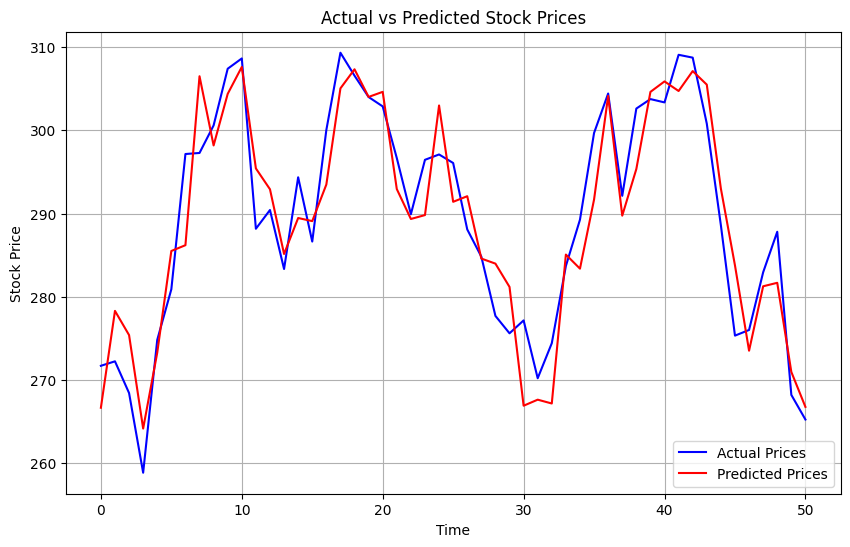

In [37]:
# Make predictions and evaluate performance
def predict_and_evaluate_xgb(xgb_model, X_test, y_test, scaler_y):
    """
    Make predictions using the trained XGBoost model and evaluate the performance.

    Parameters:
    xgb_model (XGBRegressor): Trained XGBoost model.
    X_test (np.ndarray): Test data for features.
    y_test (np.ndarray): Test data for target variable.
    scaler_y (MinMaxScaler): Scaler used for the target variable.

    Returns:
    y_test_actual (np.ndarray): Actual values of the target variable.
    y_pred_actual (np.ndarray): Predicted values of the target variable.
    """
    # Predict on the test set
    y_pred_scaled = xgb_model.predict(X_test)

    # Inverse transform the predictions and test target to original scale
    y_test_actual = scaler_y.inverse_transform(y_test)
    y_pred_actual = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    print(f"Train Root Mean Squared Error (RMSE): {rmse}")
    print(f"Test  Root Mean Squared Error (RMSE): {test_rmse:.2f}")

    return y_test_actual, y_pred_actual

# Preprocess the stock data
start_date = '2021-09-30'
end_date = '2022-09-30'
X_train, X_test, y_train, y_test, scaler_X, scaler_y = preprocess_stock_data(stock_data, start_date, end_date)

# Train the XGBoost model
xgb_model = build_and_train_xgb_model(X_train, y_train, X_test, y_test)

# Predict and evaluate
y_test_actual, y_pred_actual = predict_and_evaluate_xgb(xgb_model, X_test, y_test, scaler_y)

# Display actual vs predicted
comparison_df = pd.DataFrame({'Actual': y_test_actual.ravel(), 'Predicted': y_pred_actual.ravel()})
print("\nActual vs Predicted:")
print(comparison_df.head())

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(y_pred_actual, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# Preprocessing function of the stock data for the LSTM model
def preprocess_stock_data_lstm(data, feature_columns, target_column, look_back=60):
    """
    Prepare data for LSTM model by creating sequences.

    Parameters:
        data (pd.DataFrame): Stock data with features and target column.
        feature_columns (list): Columns used as features.
        target_column (str): Column to be predicted.
        look_back (int): Number of past time steps to use as input.

    Returns:
        X, y: Features and target arrays for training/testing.
    """
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[feature_columns + [target_column]])

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i - look_back:i, :-1])  # Features (all except target)
        y.append(scaled_data[i, -1])  # Target (last column)
    return np.array(X), np.array(y), scaler


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - loss: 0.0103 - val_loss: 0.0029
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 9.0440e-04 - val_loss: 0.0024
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 7.6997e-04 - val_loss: 0.0081
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - loss: 8.7020e-04 - val_loss: 0.0058
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - loss: 7.8549e-04 - val_loss: 0.0019
Epoch 8/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 5.8910e-04 - val_loss: 0.0018
Epoch 9/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - loss: 6.3429e-04 - val_loss: 0.0019
Epoch 10/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 7.2921e-04 - val_loss: 0.0051
Epoch 11/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 8.7656e-04 - val_loss: 0.002

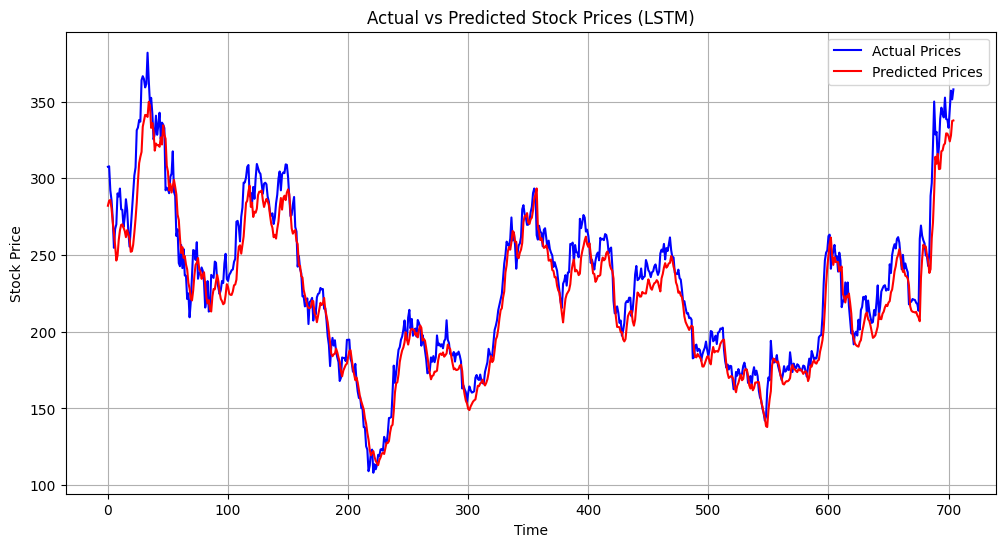

In [43]:
# Define LSTM model
def build_lstm_model(input_shape):
    """
    Build and compile an LSTM model.

    Parameters:
        input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
        model: Compiled LSTM model.
    """
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Prepare data
look_back = 60
feature_columns = ['Open', 'High', 'Low', 'SMA_20', 'SMA_50', 'EMA_50', 'EMA_200', 'MACD', 'MACD_Signal', 'MACD_Histogram', 'RSI', 'ADX', 'Plus_DI', 'Minus_DI']
target_column = 'Close'
X, y, scaler = preprocess_stock_data_lstm(stock_data, feature_columns, target_column, look_back=look_back)

# Split into train/test sets (80/20)
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build and train LSTM model
model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predictions
y_pred_scaled = model.predict(X_test)
y_test_actual = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], len(feature_columns))), y_test.reshape(-1, 1))))[:, -1]
y_pred_actual = scaler.inverse_transform(np.hstack((np.zeros((y_pred_scaled.shape[0], len(feature_columns))), y_pred_scaled)))[:, -1]

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print(f"Train Root Mean Squared Error (RMSE): {rmse}")
print(f"Test Root Mean Squared Error (RMSE): {test_rmse:.2f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(y_pred_actual, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Stock Prices (LSTM)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

###**SENTIMENT DATA**

In [ ]:
# Import and mount Google Drive.
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/stock_tweets.csv"
stock_tweets = pd.read_csv(file_path)
stock_tweets.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [ ]:
# Checking the data structure and summary of the sentiment data
print("Data Info:")
stock_tweets.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80793 entries, 0 to 80792
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          80793 non-null  object
 1   Tweet         80793 non-null  object
 2   Stock Name    80793 non-null  object
 3   Company Name  80793 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


In [ ]:
# Display the basic statistical details of the sentiment data
print("\nData Description:")
stock_tweets.describe(include='all')


Data Description:


,Date,Tweet,Stock Name,Company Name
count,80793,80793,80793,80793
unique,64424,64479,25,25
top,2022-07-07 18:32:41+00:00,$TSLA will triple in 2022 🚀🌕,TSLA,"Tesla, Inc."
freq,14,25,37422,37422


In [ ]:
#Checking for missing values
print("\nMissing Values:")
stock_tweets.isnull().sum()



Missing Values:


,0
Date,0
Tweet,0
Stock Name,0
Company Name,0


In [ ]:
# Checking for duplicates tweets
duplicate_count = stock_tweets.duplicated().sum()
print(f"\nNumber of Duplicate Entries: {duplicate_count}")


Number of Duplicate Entries: 0


In [ ]:
# Count stock mentions
stock_counts = stock_tweets['Stock Name'].value_counts()
print("\nMost Mentioned Stocks:")
stock_counts.head()


Most Mentioned Stocks:


,count
Stock Name,
TSLA,37422
TSM,11034
AAPL,5056
PG,4089
AMZN,4089


In [ ]:
#Convert 'Date' to datetime and extract Year, Month, Day, Hour
stock_tweets['Date'] = pd.to_datetime(stock_tweets['Date'], errors='coerce')


<ipython-input-38-fe002e256a76>:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  stock_tweets['Month_Year'] = stock_tweets['Date'].dt.to_period('M')
<ipython-input-38-fe002e256a76>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stock_counts.index[:10], y=stock_counts.values[:10], palette='viridis')


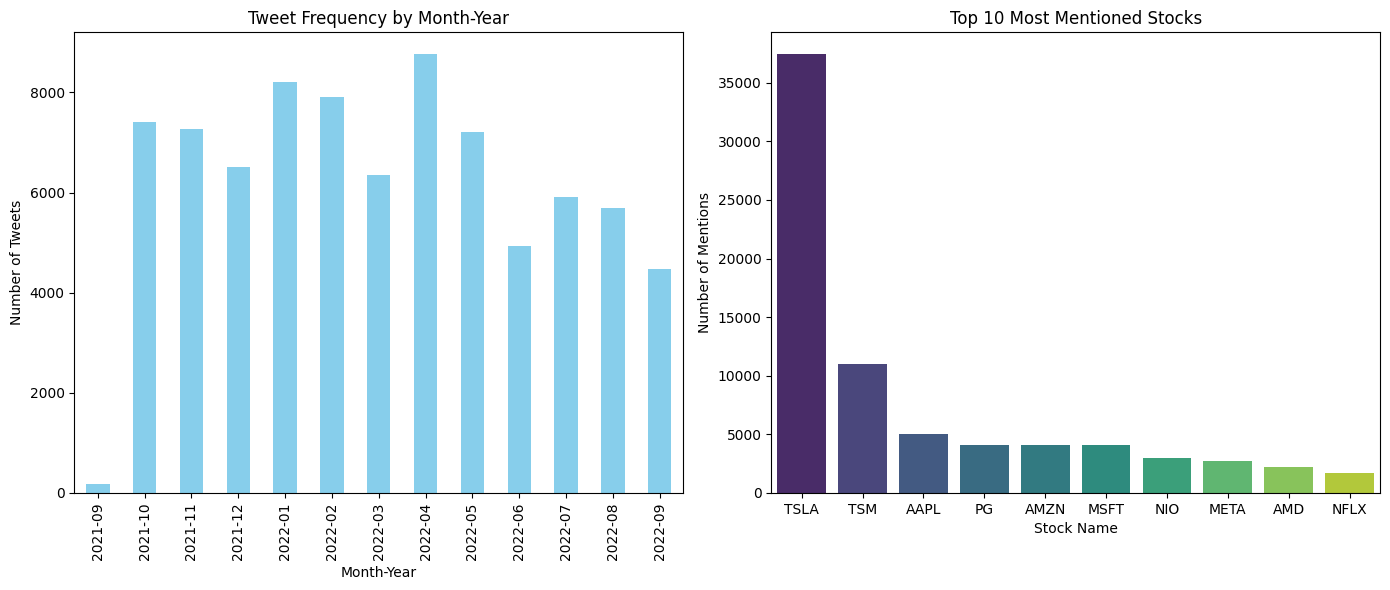

In [ ]:
# Visualising tweet frequncy and top most mentioned tweet of the sentiment data
plt.figure(figsize=(14, 6))

# Tweet Frequency by Year and Month
plt.subplot(1, 2, 1)
stock_tweets['Month_Year'] = stock_tweets['Date'].dt.to_period('M')
stock_tweets['Month_Year'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Tweet Frequency by Month-Year")
plt.xlabel("Month-Year")
plt.ylabel("Number of Tweets")

# Stock Mentions
plt.subplot(1, 2, 2)
sns.barplot(x=stock_counts.index[:10], y=stock_counts.values[:10], palette='viridis')
plt.title("Top 10 Most Mentioned Stocks")
plt.xlabel("Stock Name")
plt.ylabel("Number of Mentions")

plt.tight_layout()
plt.show()

In [ ]:
# We working with the TSLA tweet for this project
# Filtering the rows where the stock name is "TSLA" and create a dataframe
if 'Stock Name' in stock_tweets.columns:
    tsla_df = stock_tweets[stock_tweets['Stock Name'] == 'TSLA']
    print("\nFiltered Dataset (TSLA):")
else:
    print("\nError: Column 'Stock' does not exist in the dataset.")
tsla_df.head()



Filtered Dataset (TSLA):


,Date,Tweet,Stock Name,Company Name,Month_Year
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",2022-09
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",2022-09
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",2022-09
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",2022-09
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",2022-09


****SENTIMENT (TSLA TWEET) DATA EXPLORATORY DATA ANALYSIS****

<ipython-input-40-0b95bc8f53e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_df['Tweet_Length'] = tsla_df['Tweet'].apply(len)


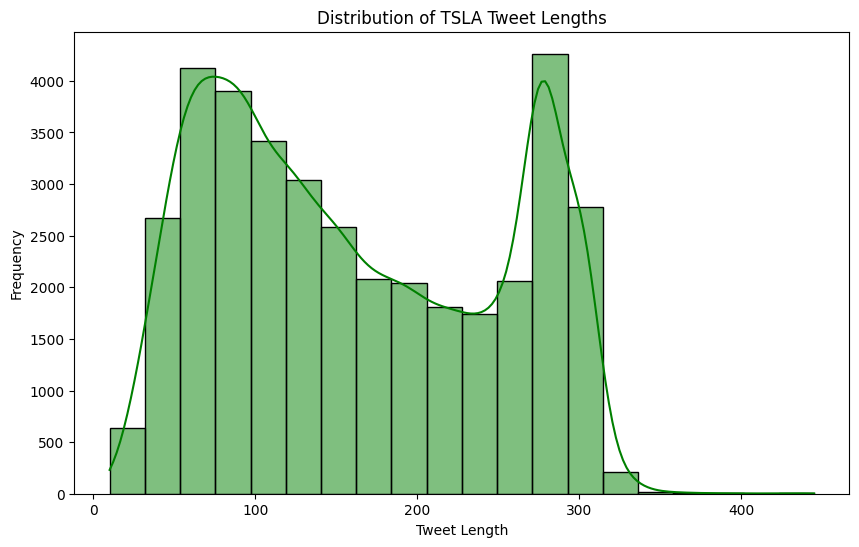

In [ ]:
# Visualising the distribution of the TSLA tweet lenghts

tsla_df['Tweet_Length'] = tsla_df['Tweet'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(tsla_df['Tweet_Length'], kde=True, color='green', bins=20)
plt.title("Distribution of TSLA Tweet Lengths")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.show()


<ipython-input-41-52a926e02272>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_df['Hour'] = tsla_df['Date'].dt.hour
<ipython-input-41-52a926e02272>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tweet_counts_by_hour.index, y=tweet_counts_by_hour.values, palette='Blues')


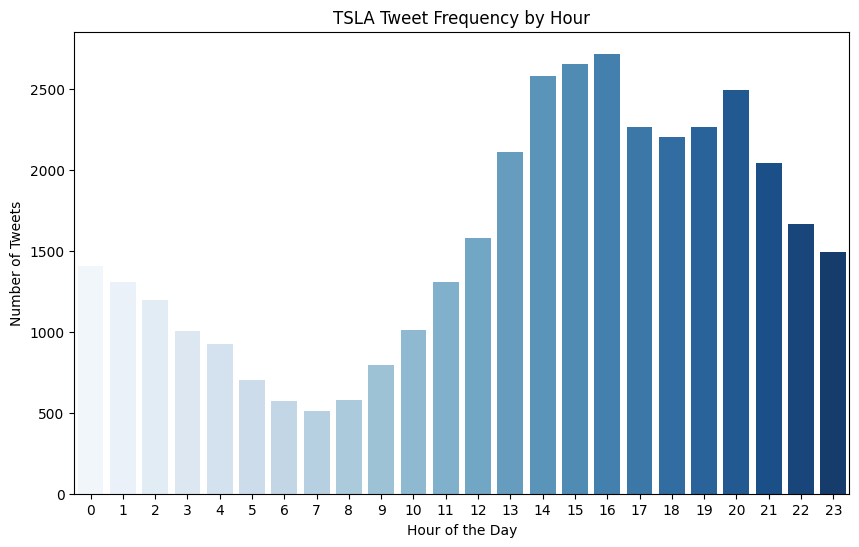

In [ ]:
# Visualising the TSLA tweet frequency by hour
tsla_df['Hour'] = tsla_df['Date'].dt.hour
tweet_counts_by_hour = tsla_df['Hour'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=tweet_counts_by_hour.index, y=tweet_counts_by_hour.values, palette='Blues')
plt.title("TSLA Tweet Frequency by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Tweets")
plt.show()


<ipython-input-42-01be463105d6>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  tsla_df['Month_Year'] = tsla_df['Date'].dt.to_period('M')
<ipython-input-42-01be463105d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_df['Month_Year'] = tsla_df['Date'].dt.to_period('M')


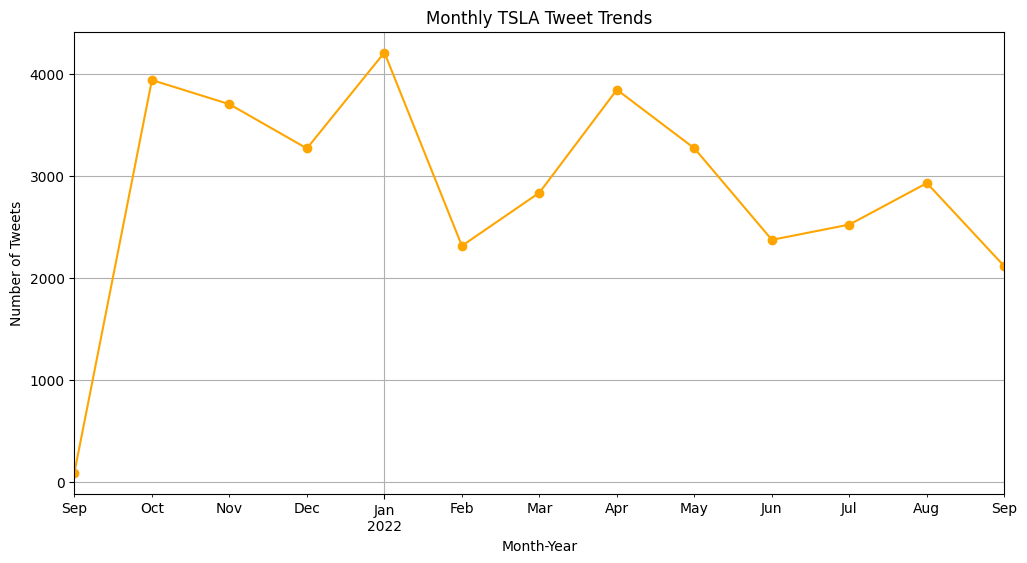

In [ ]:
# Visualising the TSLA tweet frequency by months of the year
tsla_df['Month_Year'] = tsla_df['Date'].dt.to_period('M')
monthly_tweet_counts = tsla_df['Month_Year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
monthly_tweet_counts.plot(kind='line', marker='o', color='orange')
plt.title("Monthly TSLA Tweet Trends")
plt.xlabel("Month-Year")
plt.ylabel("Number of Tweets")
plt.grid()
plt.show()


****PREPROCESSING THE TSLA TWEET DATA****

In [ ]:
# Downloading the NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to clean the tweet text
def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'@\S+', '', tweet)  # Remove mentions
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)  # Remove non-alphabetic characters
    tweet = tweet.lower()  # Convert to lowercase
    tweet = ' '.join([word for word in tweet.split() if word not in stop_words])  # Remove stop words
    return tweet

# Clean the tweet column
tsla_df['Cleaned_Tweet'] = tsla_df['Tweet'].apply(clean_tweet)

# Check cleaned data
tsla_df[['Tweet', 'Cleaned_Tweet']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-43-5b0372eda7db>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_df['Cleaned_Tweet'] = tsla_df['Tweet'].apply(clean_tweet)


,Tweet,Cleaned_Tweet
0,Mainstream media has done an amazing job at br...,mainstream media done amazing job brainwashing...
1,Tesla delivery estimates are at around 364k fr...,tesla delivery estimates around k analysts tsla
2,3/ Even if I include 63.0M unvested RSUs as of...,even include unvested rsus additional equity n...
3,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,hahaha still trying stop tesla fsd bro get shi...
4,"@RealDanODowd @Tesla Stop trying to kill kids,...",stop trying kill kids sad deranged old man


In [ ]:
# Load pre-trained sentiment analysis pipeline from HuggingFace
sentiment_analyzer = pipeline('sentiment-analysis')

# Function to predict sentiment for each tweet
def get_sentiment_score(tweet):
    result = sentiment_analyzer(tweet)
    return result[0]['label'], result[0]['score']

# Apply sentiment analysis to the cleaned tweets
tsla_df[['Sentiment', 'Sentiment_Score']] = tsla_df['Cleaned_Tweet'].apply(lambda x: pd.Series(get_sentiment_score(x)))

# Check the results
tsla_df[['Cleaned_Tweet', 'Sentiment', 'Sentiment_Score']].head()


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

<ipython-input-44-20bcdc05feef>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_df[['Sentiment', 'Sentiment_Score']] = tsla_df['Cleaned_Tweet'].apply(lambda x: pd.Series(get_sentiment_score(x)))
<ipython-input-44-20bcdc05feef>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_df[['Sentiment', 'Sentiment_Score']] = tsla_df['Cleaned_Tweet'].apply(lambda x: pd.Series(get_sentiment_score(x)))


,Cleaned_Tweet,Sentiment,Sentiment_Score
0,mainstream media done amazing job brainwashing...,NEGATIVE,0.981137
1,tesla delivery estimates around k analysts tsla,NEGATIVE,0.954435
2,even include unvested rsus additional equity n...,NEGATIVE,0.997324
3,hahaha still trying stop tesla fsd bro get shi...,NEGATIVE,0.999142
4,stop trying kill kids sad deranged old man,NEGATIVE,0.994961


In [ ]:
# Feature engineering: tweet length, number of hashtags, mentions, and sentiment scores
tsla_df['Tweet_Length'] = tsla_df['Cleaned_Tweet'].apply(len)
tsla_df['Num_Hashtags'] = tsla_df['Tweet'].apply(lambda x: len(re.findall(r'#\w+', x)))
tsla_df['Num_Mentions'] = tsla_df['Tweet'].apply(lambda x: len(re.findall(r'@\w+', x)))

# Group by date and aggregate sentiment scores for daily features
tsla_df['Date'] = tsla_df['Date'].dt.date  # Convert to date only
daily_sentiment = tsla_df.groupby('Date').agg(
    avg_sentiment_score=('Sentiment_Score', 'mean'),
    total_tweets=('Sentiment', 'count'),
    avg_tweet_length=('Tweet_Length', 'mean'),
    avg_num_hashtags=('Num_Hashtags', 'mean'),
    avg_num_mentions=('Num_Mentions', 'mean')
).reset_index()

# Check aggregated data
daily_sentiment.head()


<ipython-input-45-a612cfefa8e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_df['Tweet_Length'] = tsla_df['Cleaned_Tweet'].apply(len)
<ipython-input-45-a612cfefa8e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_df['Num_Hashtags'] = tsla_df['Tweet'].apply(lambda x: len(re.findall(r'#\w+', x)))
<ipython-input-45-a612cfefa8e2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

,Date,avg_sentiment_score,total_tweets,avg_tweet_length,avg_num_hashtags,avg_num_mentions
0,2021-09-30,0.933956,90,99.200000,0.277778,0.655556
1,2021-10-01,0.946215,94,98.978723,0.191489,0.734043
2,2021-10-02,0.936372,116,88.103448,0.232759,0.620690
3,2021-10-03,0.935579,61,108.868852,0.213115,0.639344
4,2021-10-04,0.934877,119,83.319328,0.134454,0.445378


****FEATURE ENGINEERING****

In [ ]:
# Ensure 'Date' is a column, not an index
if 'Date' not in stock_data.columns:
    stock_data = stock_data.reset_index()  # Reset index to move 'Date' back to a column

if 'Date' not in daily_sentiment.columns:
    daily_sentiment = daily_sentiment.reset_index()

# Convert 'Date' columns in both DataFrames to the same format
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date  # Convert to datetime.date
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date']).dt.date

# Merge stock data with daily sentiment data
data = pd.merge(stock_data, daily_sentiment, on='Date', how='inner')

# Check the merged data
data.head()


,Date,Open,High,Low,Close,SMA_20,SMA_50,EMA_50,EMA_200,MACD,...,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI,avg_sentiment_score,total_tweets,avg_tweet_length,avg_num_hashtags,avg_num_mentions
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,251.648502,239.699468,241.751282,216.204206,5.700370,...,0.420555,64.298745,14.286528,25.602899,17.336323,0.933956,90,99.200000,0.277778,0.655556
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,252.362336,240.539202,242.404434,216.624131,5.558636,...,0.223057,62.331602,13.902687,25.350030,21.201050,0.946215,94,98.978723,0.191489,0.734043
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,253.161670,241.460202,243.114457,217.060807,5.552032,...,0.173163,63.671942,14.694541,31.289169,18.778048,0.934877,119,83.319328,0.134454,0.445378
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,253.622836,242.280002,243.784347,217.490019,5.458591,...,0.063777,59.899231,15.307149,28.609253,17.807568,0.951680,88,104.340909,0.204545,0.659091
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,254.104169,243.199802,244.456202,217.922125,5.380611,...,-0.011362,60.217334,15.809982,26.378192,16.742171,0.953122,78,85.474359,0.448718,0.474359


In [ ]:
data.describe()

,Open,High,Low,Close,SMA_20,SMA_50,EMA_50,EMA_200,MACD,MACD_Signal,MACD_Histogram,RSI,ADX,Plus_DI,Minus_DI,avg_sentiment_score,total_tweets,avg_tweet_length,avg_num_hashtags,avg_num_mentions
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,300.295542,307.656601,292.253823,299.864947,298.490638,295.447575,295.648828,274.320579,1.274973,1.336358,-0.061384,52.759431,23.227792,26.823695,24.396274,0.952179,119.158730,94.150179,0.261508,0.622200
std,46.161120,46.804121,44.718813,45.812123,41.103250,35.085854,30.842219,20.867372,12.654949,11.745764,4.234958,17.911393,10.051226,9.147891,7.474003,0.010649,51.443608,7.645160,0.100036,0.212580
min,207.949997,217.973328,206.856674,209.386673,231.434334,237.535334,241.751282,216.204206,-25.271333,-22.213158,-7.678481,15.436319,9.382026,9.095958,1.954825,0.921067,46.000000,72.496350,0.065217,0.175182
25%,266.860825,273.241661,260.780823,267.203331,265.233167,263.703535,269.207022,273.137595,-9.307914,-9.294600,-3.443494,40.606929,16.465301,20.440324,20.271608,0.944997,87.000000,88.635706,0.192211,0.481928
50%,298.750000,304.158325,289.565002,296.856659,292.829167,300.646933,298.850483,279.662658,1.506031,2.278616,0.223006,49.667595,20.898588,25.585256,25.056400,0.952351,103.000000,94.407450,0.250000,0.590082
75%,335.700005,344.957512,327.908340,336.472504,338.758374,319.797798,322.985639,286.566026,9.424874,9.324321,2.517216,62.951301,26.342963,31.204020,29.368782,0.959339,135.500000,99.596330,0.309643,0.723676
max,411.470001,414.496674,405.666656,409.970001,373.152498,357.870532,344.030730,298.242573,38.067930,31.285426,10.296174,97.129203,63.325957,66.743503,44.249155,0.975639,462.000000,109.414634,0.683673,1.416667


In [ ]:
data.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
SMA_20,0
SMA_50,0
EMA_50,0
EMA_200,0
MACD,0


In [ ]:
data.shape

(252, 21)

In [ ]:
# Feature Engineering
feature_columns = data.columns.difference(['Date', 'Close'])
target_column = 'Close'

# Handle missing values (if any)
data = data.dropna()

# Split features and target
X = data[feature_columns]
y = data[target_column]

# Scale data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)


In [ ]:
# --- Linear Regression ---
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

# Evaluate
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_test_pred))
print(f"Linear Regression RMSE: {lr_rmse}")

Linear Regression RMSE: 0.021971340735846303


In [ ]:
# --- XGBoost ---
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

# Predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)

# Evaluate
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_pred))
print(f"XGBoost RMSE: {xgb_rmse}")

XGBoost RMSE: 0.028987525857754295


In [ ]:
# --- LSTM ---
# Reshape data for LSTM (3D input: samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)

# Predictions
lstm_train_pred = lstm_model.predict(X_train_lstm)
lstm_test_pred = lstm_model.predict(X_test_lstm)

# Evaluate
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_test_pred))
print(f"LSTM RMSE: {lstm_rmse}")



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 0.2841 - val_loss: 0.1098
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1814 - val_loss: 0.0619
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1317 - val_loss: 0.0197
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0772 - val_loss: 0.0041
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0406 - val_loss: 0.0257
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0440 - val_loss: 0.0238
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0361 - val_loss: 0.0103
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0290 - val_loss: 0.0057
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0274 - val_loss: 0.0055
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0238 - val_loss: 0.0071
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0203 - val_loss: 0.0069
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0183 - val_loss: 0.0050
Epoch 13/50


In [ ]:
from tensorflow.keras.models import save_model
import joblib  # Correct import for saving Scikit-learn models

# Define file paths
lstm_model_path = 'model_lstm.keras'
xgb_model_path = 'model_xgb.json'
linear_model_path = 'model_linear.pkl'

# Save the LSTM model
save_model(lstm_model, lstm_model_path)
print(f"LSTM model saved as '{lstm_model_path}'")

# Save the XGBoost model
xgb_model.save_model(xgb_model_path)
print(f"XGBoost model saved as '{xgb_model_path}'")

# Save the Linear Regression model
joblib.dump(linear_model, linear_model_path)
print(f"Linear Regression model saved as '{linear_model_path}'")



LSTM model saved as 'model_lstm.keras'
XGBoost model saved as 'model_xgb.json'
Linear Regression model saved as 'model_linear.pkl'


In [ ]:
# Load the saved models
def load_saved_models():
    """
    Load the saved models from disk.

    Returns:
    tuple: A tuple containing the loaded LSTM, XGBoost, and Linear Regression models.
    """
    # Load the LSTM model
    lstm_model = load_model('model_lstm.keras')
    print("LSTM model loaded successfully.")

    # Load the XGBoost model
    xgb_model = xgb.Booster()
    xgb_model.load_model('model_xgb.json')
    print("XGBoost model loaded successfully.")

    # Load the Linear Regression model
    linear_model = joblib.load('model_linear.pkl')
    print("Linear Regression model loaded successfully.")

    return lstm_model, xgb_model, linear_model

In [ ]:
from tensorflow.keras.models import load_model

def load_models():
    """
    Load the saved models from disk.

    Returns:
    tuple: A tuple containing the loaded LSTM, XGBoost, and Linear Regression models.
    """
    # Load the LSTM model
    model_lstm = load_model('model_lstm.keras')
    print("LSTM model loaded successfully.")

    # Load the XGBoost model
    model_xgb = xgb.Booster()
    model_xgb.load_model('model_xgb.json')
    print("XGBoost model loaded successfully.")

    # Load the Linear Regression model
    model_linear = joblib.load('model_linear.pkl')
    print("Linear Regression model loaded successfully.")

    return model_lstm, model_xgb, model_linear

# Call the function to load models
model_lstm, model_xgb, model_linear = load_models()


LSTM model loaded successfully.
XGBoost model loaded successfully.
Linear Regression model loaded successfully.


In [ ]:
# Inverse transform predictions and actual values for LSTM
y_test_actual_lstm = scaler_y.inverse_transform(y_test.reshape(-1, 1))  # Assuming y_test is in NumPy array format
y_pred_actual_lstm = scaler_y.inverse_transform(lstm_test_pred.reshape(-1, 1))  # Predicted values from LSTM

# Inverse transform predictions and actual values for XGBoost
y_test_actual_xgb = scaler_y.inverse_transform(y_test.reshape(-1, 1))  # Reuse the same y_test
y_pred_actual_xgb = scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1))  # Predicted values from XGBoost

# Inverse transform predictions and actual values for Linear Regression
y_test_actual_linear = scaler_y.inverse_transform(y_test.reshape(-1, 1))  # Reuse the same y_test
y_pred_actual_linear = scaler_y.inverse_transform(y_pred_linear.reshape(-1, 1))  # Predicted values from Linear Regression

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).

    Parameters:
    y_true (array-like): True target values.
    y_pred (array-like): Predicted target values.

    Returns:
    float: The MAPE value.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate and return evaluation metrics for the models
def evaluate_model(y_true, y_pred, model_name):
    """
    Calculate and return evaluation metrics for a regression model.

    Parameters:
    y_true (array-like): True target values.
    y_pred (array-like): Predicted target values.
    model_name (str): The name of the model being evaluated.

    Returns:
    dict: A dictionary containing the evaluation metrics.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    metrics = {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    }

    return metrics

# Evaluate models
lstm_metrics = evaluate_model(y_test_actual_lstm, y_pred_actual_lstm, "LSTM")
xgb_metrics = evaluate_model(y_test_actual_xgb, y_pred_actual_xgb, "XGBoost")
linear_metrics = evaluate_model(y_test_actual_linear, y_pred_actual_linear, "Linear Regression")

# Combine all metrics into a DataFrame and display
all_metrics = pd.DataFrame([lstm_metrics, xgb_metrics, linear_metrics])
print(all_metrics)


NameError: name 'y_pred_xgb' is not defined

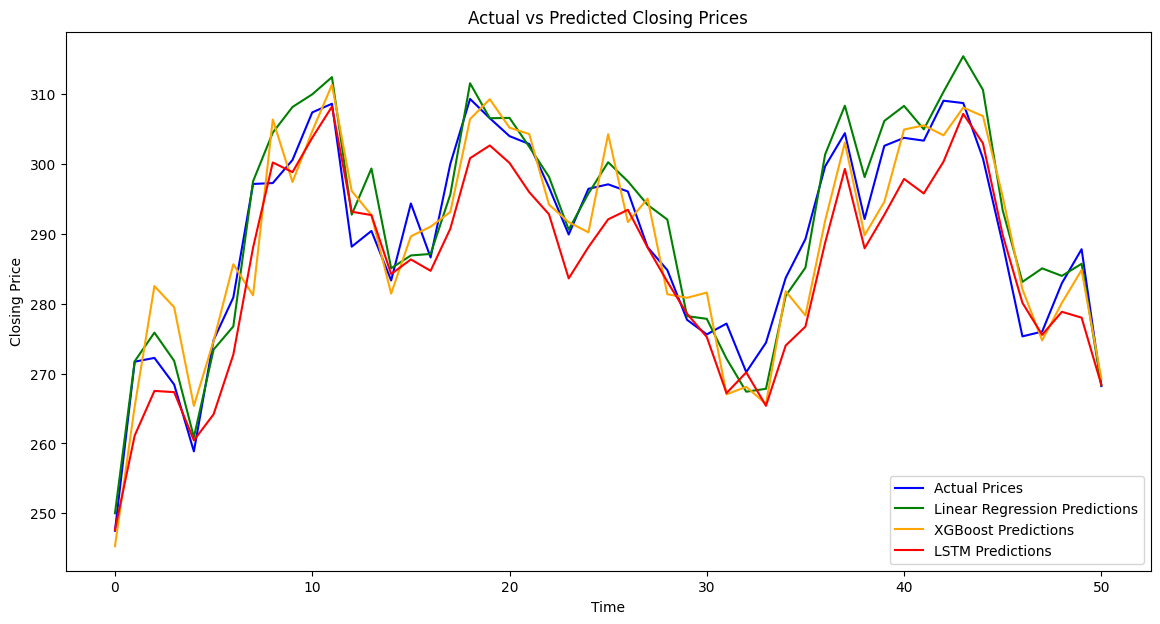

In [ ]:
# --- Results ---
# Inverse transform predictions to original scale
lr_test_pred_actual = scaler_y.inverse_transform(lr_test_pred)
xgb_test_pred_actual = scaler_y.inverse_transform(xgb_test_pred.reshape(-1, 1))
lstm_test_pred_actual = scaler_y.inverse_transform(lstm_test_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

# Plot actual vs predicted
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(lr_test_pred_actual, label='Linear Regression Predictions', color='green')
plt.plot(xgb_test_pred_actual, label='XGBoost Predictions', color='orange')
plt.plot(lstm_test_pred_actual, label='LSTM Predictions', color='red')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()